In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [13]:
import pandas as pd
import numpy as np
from itertools import product

In [3]:
from Bio import SeqIO
import requests
from StringIO import StringIO 

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn import svm
import sklearn

Processing the data
---------

In [4]:
# parse the excel into pandas dataframe

df = pd.read_excel('SERCaMP Library Gene List with mass spec.xlsx', header = 1, parse_cols='B:Q')

df = df.dropna(axis = 0, how = 'all')

s = pd.Series([''.join(df.iloc[i, 4:11]) for i in range(df.shape[0])])
df['tail'] = s.values

n_pos = np.where(df.index.values == 'SERCaMP (+)')[0][0] 
label = [0] * n_pos + [1] * (df.shape[0] - n_pos)
df['Label'] = label

df = df.drop(['Number', 'Amino Acids'] + ['Unnamed: %d' %(i+5) for i in range(7)], axis = 1)

df = df.set_index('UniProt ')

# here I know this one is wrong, so I correct it
df['tail'][34] = 'PQPRDEL'

/share/apps/python/anaconda-4.2.0/lib/python2.7/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
# df.to_pickle('tail_response.df')

In [ ]:
# get the whole seq from uniprot
# not really needed for the analysis below

def getFasta(code):
    if len(code.split(',')) == 2: code = code.split(',')[0]
    params = {"query": code, "format": "fasta"}
    response = requests.get("http://www.uniprot.org/uniprot/", params)

    for r in SeqIO.parse(StringIO(response.text), "fasta"): 
        return str(r.seq)

fullSeq = [getFasta(code) for code in df.index]

# verify all the sequences are correct
for i, code in enumerate(df.index):
    if fullSeq[i][-7:] != df['tail'][i]: print i, code

df['fullSeq'] = fullSeq

In [14]:
df.head()

,Protein Name,Gene,Tg Response - 24hr,Tg Response - 8hr,Mass Spec Response,tail,Label,fullSeq
UniProt,,,,,,,,
Q13438,Protein OS-9,OS9,0.850897,0.938353,NaN,DLDEFDF,0,MAAETLLSSLLGLLLLGLLLPASLTGGVGSLNLEELSEMRYGIEIL...
P01298,Pancreatic prohormone,PPY,1.027749,0.935511,NaN,ELSPLDL,0,MAAARLCLSLLLLSTCVALLLQPLLGAQGAPLEPVYPGDNATPEQM...
Q14113,Adipocyte enhancer-binding protein 1,AEBP1,1.202366,1.156462,NaN,TVNFGDF,0,MAAVRGAPLLSCLLALLALCPGGRPQTVLTDDEIEEFLEGFLSELE...
Q12860,Contactin-1,CNTN1,1.173510,1.335114,0.865912,ILVYLEF,0,MKMWLLVSHLVIISITTCLAEFTWYRRYGHGVSEEDKGFGPIFEEQ...
Q9BLZ2,"""Untagged"" Gaussia Luciferase",Untagged,1.106812,0.903370,NaN,IKGAGGD,0,MGVKVLFALICIAVAEAKPTENNEDFNIVAVASNFATTDLDADRGK...


In [3]:
# df = pd.read_pickle('tail_response.df')

conjoint triad method
----------

In [5]:
# group the a.a. into 7 groups

aa2num = {'A': 1, 'G': 1, 'V': 1, 'I': 2, 'L': 2, 'F': 2, 'P': 2, 
          'Y': 3, 'M': 3, 'T': 3, 'S': 3, 'H': 4, 'N': 4, 'Q': 4,
          'W': 4, 'R': 5, 'K': 5, 'D': 6, 'E': 6, 'C': 7}

num2aa = {1: ['A', 'G', 'V'], 2: ['I', 'L', 'F', 'P'], 3: ['Y', 'M', 'T', 'S'],
          4: ['N', 'Q', 'W'], 5: ['R', 'K'], 6: ['D', 'E'], 7: ['C']}

In [6]:
def ct_code(seq):
    """ generate the CT vector """
    num_code = [aa2num[s] for s in seq]
    triple_code = [num_code[i:i+3] for i in range(len(num_code) - 2)]
    ct = np.zeros(343, dtype=float)
    
    for c in triple_code:
        index = (c[2] - 1) * 49 + (c[1] - 1) * 7 + c[0] - 1
        ct[index] += 1
        
    return ct / ct.sum()

In [7]:
# build the dataset using CT methods

x = [ct_code(s) for s in df['tail']]
y = df['Tg Response - 8hr'].values

Random Forest Regression
---------

In [ ]:
estimator = RandomForestRegressor(random_state=42)
param = {'n_estimators': (50, 100, 500), 'max_features': ['auto', 'sqrt', 'log2'], 
         'max_depth': [4, 5, 6]}

clf = sklearn.grid_search.GridSearchCV(estimator, param, n_jobs = -1)
clf.fit(x, y)

In [208]:
print clf.best_params_,  clf.best_score_

{'max_features': 'sqrt', 'n_estimators': 50, 'max_depth': 4} -0.965782736809


In [213]:
estimator = RandomForestRegressor(random_state=42)
param = {'n_estimators': (20, 50, 70), 'max_features': ['auto', 'sqrt', 'log2'], 
         'max_depth': [2, 3, 4]}

clf = sklearn.grid_search.GridSearchCV(estimator, param, n_jobs = -1)
clf.fit(x, y)
print clf.best_params_,  clf.best_score_

{'max_features': 'sqrt', 'n_estimators': 50, 'max_depth': 4} -0.965782736809


Gradient Boosting Regression
------------

In [212]:
estimator = GradientBoostingRegressor(random_state=42)
param = {'learning_rate': [1e-4, 1e-3, 1e-2, 1e-1, 1], 'n_estimators': (50, 100, 500), 
         'max_features': ['auto', 'sqrt', 'log2'], 'subsample': [0.5, 0.8, 1], 
         'max_depth': [3, 4, 5, 6]}
clf = sklearn.grid_search.GridSearchCV(estimator, param, n_jobs = -1)
clf.fit(x, y)
print clf.best_params_,  clf.best_score_

{'max_features': 'sqrt', 'n_estimators': 50, 'learning_rate': 0.1, 'max_depth': 4, 'subsample': 0.5} -0.847122983253


In [214]:
estimator = GradientBoostingRegressor(random_state=42)
param = {'learning_rate': [1e-1], 'n_estimators': (30, 50, 70), 
         'max_features': ['auto', 'sqrt', 'log2'], 'subsample': [0.3, 0.4, 0.5, 0.6], 
         'max_depth': [4]}
clf = sklearn.grid_search.GridSearchCV(estimator, param, n_jobs = -1)
clf.fit(x, y)
print clf.best_params_,  clf.best_score_

{'max_features': 'sqrt', 'n_estimators': 50, 'learning_rate': 0.1, 'max_depth': 4, 'subsample': 0.5} -0.847122983253


Support Vector Regression
----------

In [217]:
estimator = svm.SVR()
param = {'C': (0.01, 0.1, 1, 10), 'epsilon':(0.01, 0.1, 1, 10), 'kernel': ('rbf', 'linear', 'poly', 'sigmoid'),
         'degree': (2, 3, 4), 'gamma': (1e-3, 1e-2, 1e-1), 'coef0': (1e-1, 0, 1)}

clf = sklearn.grid_search.GridSearchCV(estimator, param, n_jobs = -1)
clf.fit(x, y)
print clf.best_params_,  clf.best_score_

{'kernel': 'poly', 'C': 10, 'degree': 4, 'epsilon': 0.1, 'coef0': 1, 'gamma': 0.1} -0.859667277421


In [22]:
estimator = svm.SVR()
param = {'C': (10, 100), 'epsilon':(0.1, ), 'kernel': ('poly',),
         'degree': (4, 5), 'gamma': (1e-1, 1), 'coef0': (1, 10)}

clf = sklearn.grid_search.GridSearchCV(estimator, param, n_jobs = -1)
clf.fit(x, y)
print clf.best_params_,  clf.best_score_

{'kernel': 'poly', 'C': 10, 'degree': 5, 'epsilon': 0.1, 'coef0': 1, 'gamma': 0.1} -0.859330202206


In [64]:
estimator = svm.SVR()
param = {'C': (0.01, 0.1, 1, 10), 'epsilon':(0.01, 0.1, 1, 10), 'kernel': ('linear',),
         'degree': (2, 3, 4), 'gamma': (1e-3, 1e-2, 1e-1), 'coef0': (1e-1, 0, 1)}

clf = sklearn.grid_search.GridSearchCV(estimator, param, n_jobs = -1)
clf.fit(x, y)
print clf.best_params_,  clf.best_score_

{'kernel': 'linear', 'C': 1, 'degree': 2, 'epsilon': 0.1, 'coef0': 0.1, 'gamma': 0.001} -0.923943340339


Autocovariance method
-----------

In [9]:
# read in the a.a. chemphysical property data
aa_property = pd.read_csv('aa_property.csv', header=None, index_col=0)

In [10]:
def autocovar(seq, lag = 1):
    n = len(seq)
    result = np.zeros(7)
    property_m = np.array([])
    
    for aa in seq:
        if property_m.size == 0: property_m = aa_property.loc[aa]
        else: property_m = np.vstack((property_m, aa_property.loc[aa]))
    
    mean_property = np.mean(property_m, axis = 0)
    
    for i in range(7):
        for j in range(n - lag):
            result[i] += (property_m[j, i] - mean_property[i]) * (property_m[j + lag, i] - mean_property[i])
        
        result[i] /= (n - lag)
    
    return result

In [11]:
ac_x_1 = [autocovar(s) for s in df['tail']]
ac_x_2 = [autocovar(s, 2) for s in df['tail']]
ac_x_3 = [autocovar(s, 3) for s in df['tail']]

In [81]:
estimator = RandomForestRegressor(random_state=42)
param = {'n_estimators': (50, 100, 500), 'max_features': ['auto', 'sqrt', 'log2'], 
         'max_depth': [4, 5, 6]}

clf = sklearn.grid_search.GridSearchCV(estimator, param, n_jobs = -1)
clf.fit(ac_x_1, y)

print clf.best_params_,  clf.best_score_

{'max_features': 'sqrt', 'n_estimators': 500, 'max_depth': 4} -4.94904177194


In [82]:
estimator = RandomForestRegressor(random_state=42)
param = {'n_estimators': (2000, 5000), 'max_features': ['auto', 'sqrt', 'log2'], 
         'max_depth': [2, 3, 4]}

clf = sklearn.grid_search.GridSearchCV(estimator, param, n_jobs = -1)
clf.fit(ac_x_1, y)

print clf.best_params_,  clf.best_score_

{'max_features': 'sqrt', 'n_estimators': 5000, 'max_depth': 2} -4.6506020282


In [83]:
estimator = RandomForestRegressor(random_state=42)
param = {'n_estimators': (50, 100, 500), 'max_features': ['auto', 'sqrt', 'log2'], 
         'max_depth': [3, 4, 5]}

clf = sklearn.grid_search.GridSearchCV(estimator, param, n_jobs = -1)
clf.fit(ac_x_2, y)

print clf.best_params_,  clf.best_score_

{'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 3} -5.27422738684


In [84]:
estimator = RandomForestRegressor(random_state=42)
param = {'n_estimators': (50, 100, 500), 'max_features': ['auto', 'sqrt', 'log2'], 
         'max_depth': [3, 4, 5]}

clf = sklearn.grid_search.GridSearchCV(estimator, param, n_jobs = -1)
clf.fit(ac_x_3, y)

print clf.best_params_,  clf.best_score_

{'max_features': 'sqrt', 'n_estimators': 500, 'max_depth': 3} -5.17104829218


In [85]:
estimator = GradientBoostingRegressor(random_state=42)
param = {'learning_rate': [1e-4, 1e-3, 1e-2, 1e-1, 1], 'n_estimators': (50, 100, 500), 
         'max_features': ['auto', 'sqrt', 'log2'], 'subsample': [0.5, 0.8, 1], 
         'max_depth': [3, 4, 5, 6]}
clf = sklearn.grid_search.GridSearchCV(estimator, param, n_jobs = -1)
clf.fit(ac_x_1, y)
print clf.best_params_,  clf.best_score_

{'max_features': 'auto', 'n_estimators': 50, 'learning_rate': 0.01, 'max_depth': 6, 'subsample': 0.8} -4.32814733813


In [22]:
estimator = GradientBoostingRegressor(random_state=42)
param = {'learning_rate': [1e-4, 1e-3, 1e-2, 1e-1, 1], 'n_estimators': (50, 100, 500), 
         'max_features': ['auto', 'sqrt', 'log2'], 'subsample': [0.5, 0.8, 1], 
         'max_depth': [3, 4, 5, 6]}
clf = sklearn.grid_search.GridSearchCV(estimator, param, n_jobs = -1)
clf.fit(ac_x_3, y)
print clf.best_params_,  clf.best_score_

{'max_features': 'auto', 'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 5, 'subsample': 0.5} -1.04733136404


In [23]:
estimator = GradientBoostingRegressor(random_state=42)
param = {'learning_rate': [1e-1], 'n_estimators': (500, 1000, 2000), 
         'max_features': ['auto', 'sqrt', 'log2'], 'subsample': [0.3, 0.5, 0.7], 
         'max_depth': [5]}
clf = sklearn.grid_search.GridSearchCV(estimator, param, n_jobs = -1)
clf.fit(ac_x_3, y)
print clf.best_params_,  clf.best_score_

{'max_features': 'auto', 'n_estimators': 2000, 'learning_rate': 0.1, 'max_depth': 5, 'subsample': 0.5} -1.03256123996


In [26]:
estimator = GradientBoostingRegressor(random_state=42)
param = {'learning_rate': [1e-1], 'n_estimators': (500, 1000, 2000), 
         'max_features': ['auto', 'sqrt', 'log2'], 'subsample': [0.3, 0.5, 0.7], 
         'max_depth': [5]}
clf = sklearn.grid_search.GridSearchCV(estimator, param, n_jobs = -1)
clf.fit(ac_x_2, y)
print clf.best_params_,  clf.best_score_

{'max_features': 'sqrt', 'n_estimators': 1000, 'learning_rate': 0.1, 'max_depth': 5, 'subsample': 0.7} -0.990569484804


In [27]:
estimator = svm.SVR()
param = {'C': (0.01, 0.1, 1, 10), 'epsilon':(0.01, 0.1, 1, 10), 'kernel': ('rbf', 'linear', 'poly', 'sigmoid'),
         'degree': (2,), 'gamma': (1e-3, 1e-2, 1e-1), 'coef0': (1e-1, 0, 1)}

clf = sklearn.grid_search.GridSearchCV(estimator, param, n_jobs = -1)
clf.fit(ac_x_1, y)
print clf.best_params_,  clf.best_score_

{'kernel': 'linear', 'C': 0.01, 'degree': 2, 'epsilon': 0.01, 'coef0': 0.1, 'gamma': 0.001} -0.730218918729


In [30]:
estimator = svm.SVR()
param = {'C': (1e-4, 1e-3, 0.01), 'epsilon':(1e-6, 1e-4, 0.01), 'kernel': ('linear',)}

clf = sklearn.grid_search.GridSearchCV(estimator, param, n_jobs = -1)
clf.fit(ac_x_1, y)
print clf.best_params_,  clf.best_score_

{'epsilon': 0.0001, 'C': 0.01, 'kernel': 'linear'} -0.724168266707


In [31]:
estimator = svm.SVR()
param = {'C': (1e-4, 1e-3, 0.01), 'epsilon':(1e-6, 1e-4, 0.01), 'kernel': ('linear',)}

clf = sklearn.grid_search.GridSearchCV(estimator, param, n_jobs = -1)
clf.fit(ac_x_2, y)
print clf.best_params_,  clf.best_score_

{'epsilon': 1e-06, 'C': 0.01, 'kernel': 'linear'} -1.07280027914


In [32]:
estimator = svm.SVR()
param = {'C': (1e-4, 1e-3, 0.01), 'epsilon':(1e-6, 1e-4, 0.01), 'kernel': ('linear',)}

clf = sklearn.grid_search.GridSearchCV(estimator, param, n_jobs = -1)
clf.fit(ac_x_3, y)
print clf.best_params_,  clf.best_score_

{'epsilon': 1e-06, 'C': 0.0001, 'kernel': 'linear'} -1.38749207788


use the best model to train all data and do prediction
--------------

### CT & GBRT 

In [129]:
estimator = GradientBoostingRegressor(random_state=42, learning_rate=0.1, n_estimators=50, 
                                      max_features='sqrt', subsample = 0.5, max_depth = 4)
estimator.fit(x, y)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=4, max_features='sqrt', max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=50, presort='auto',
             random_state=42, subsample=0.5, verbose=0, warm_start=False)

In [130]:
y_predict_gbrt = estimator.predict(x)

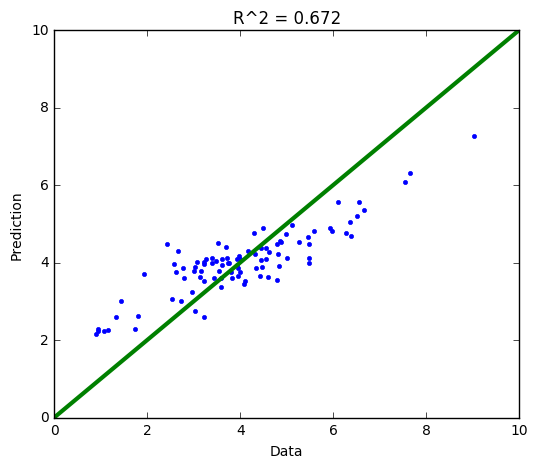

In [139]:
plt.figure(figsize=(6,5))
plt.plot(y, y_predict_gbrt, '.')
plt.plot((0, 10), (0, 10), lw = 3)
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xlabel('Data')
plt.ylabel('Prediction')
plt.title("R^2 = %.3f" %(sklearn.metrics.r2_score(y, y_predict_gbrt)) )

In [12]:
# convert CT vector back to a.a.

def ct2aa(ct):
    a2 = ct / 49 
    a1 = (ct - a2 * 49) / 7 
    a0 = ct - a2 * 49 - a1 * 7
    
    return [num2aa[a0 + 1], num2aa[a1 + 1], num2aa[a2 + 1]]

def ct2num(ct):
    a2 = ct / 49 
    a1 = (ct - a2 * 49) / 7 
    a0 = ct - a2 * 49 - a1 * 7
    
    return [a0 + 1, a1 + 1, a2 + 1]

In [113]:
# predict for unseen sequence
# since there are only seven groups of a.a., we only need to generate new seq. from AIYNRDC, each from one different group

result = {}

for c in product('AIYNRDC', repeat=7):
    code = ''.join(c)
    result[code] = estimator.predict([ct_code(code)])[0]

In [115]:
sorted(result.iteritems(), key=lambda (k,v): (v,k), reverse=True)[:50]

[('RDRRRND', 7.611246393152709),
 ('RRRNDNI', 7.364427263365557),
 ('YIRRRND', 7.3049432775702243),
 ('RRRNDDI', 7.2721556794362288),
 ('RRRNDRY', 7.2678243888483562),
 ('RRRNDRD', 7.256387195866334),
 ('RRRNDDD', 7.2562197023805073),
 ('YIYDNID', 7.1629343837086488),
 ('RRRNDDR', 7.1506462733658518),
 ('YRRRNDD', 7.1309740075415107),
 ('RRRRNDD', 7.1309740075415107),
 ('RRRNDDY', 7.1309740075415107),
 ('RRRNDDC', 7.1309740075415107),
 ('RRRNDDA', 7.1309740075415107),
 ('IRRRNDD', 7.1309740075415107),
 ('DRRRNDD', 7.1309740075415107),
 ('CRRRNDD', 7.1309740075415107),
 ('ARRRNDD', 7.1309740075415107),
 ('RRRNDRN', 7.1057446854137947),
 ('NIRRRND', 7.08807939419943),
 ('IYRRRND', 7.0771597244921782),
 ('RIRRRND', 7.0728556747860862),
 ('DDRRRND', 7.0610474503495553),
 ('YYRRRND', 7.0413751845252142),
 ('YRRRRND', 7.0413751845252142),
 ('YRRRNDY', 7.0413751845252142),
 ('YRRRNDR', 7.0413751845252142),
 ('YRRRNDN', 7.0413751845252142),
 ('YRRRNDC', 7.0413751845252142),
 ('YRRRNDA', 7.0413

### AC1 & SVR

In [116]:
svr = svm.SVR(C=0.01, epsilon=1e-4, kernel='linear')
svr.fit(ac_x_1, y)

SVR(C=0.01, cache_size=200, coef0=0.0, degree=3, epsilon=0.0001, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [120]:
y_predict_svr = svr.predict(ac_x_1)

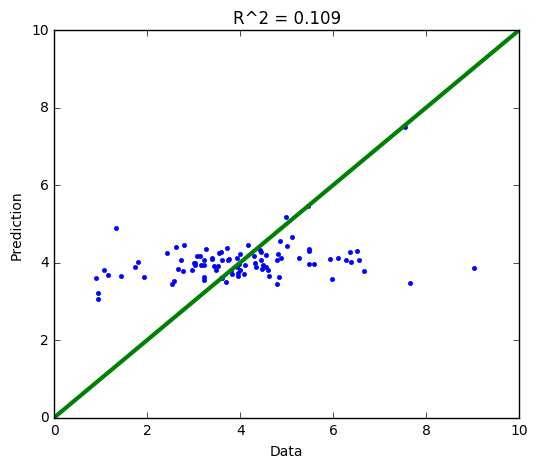

In [140]:
plt.figure(figsize=(6,5))
plt.plot(y, y_predict_svr, '.')
plt.plot((0, 10), (0, 10), lw = 3)
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xlabel('Data')
plt.ylabel('Prediction')
plt.title("R^2 = %.3f" %(sklearn.metrics.r2_score(y, y_predict_svr)) )

In [118]:
result2 = {}

for c in product('AIYNRDC', repeat=7):
    code = ''.join(c)
    result2[code] = svr.predict([autocovar(code, 1)])[0]

In [119]:
sorted(result2.iteritems(), key=lambda (k,v): (v,k), reverse=True)[:50]

[('RYIYIYR', 13.944523200820329),
 ('IYRYIYI', 13.927005907079236),
 ('IYIYRYI', 13.927005907079236),
 ('RYIYRYI', 13.91802644860323),
 ('IYRYIYR', 13.91802644860323),
 ('IYIYRYR', 13.91802644860323),
 ('RYRYIYI', 13.918026448592771),
 ('YIYRYIY', 13.917059114056572),
 ('YIYIYRY', 13.917059114056572),
 ('YRYIYIY', 13.917059114028378),
 ('IYRYRYI', 13.891529696393862),
 ('RYIYRYR', 13.885368153637645),
 ('RYRYIYR', 13.885368153623093),
 ('YRYRYIY', 13.871636110261223),
 ('YRYIYRY', 13.871636110261223),
 ('YIYRYRY', 13.871636110261223),
 ('RYIYIYI', 13.870626731650789),
 ('IYIYIYR', 13.870626731636237),
 ('IYRYRYR', 13.775995473643123),
 ('RYRYRYI', 13.775995473640394),
 ('YIYIYIY', 13.773051425911179),
 ('IYIYIYI', 13.773051425911179),
 ('NYIYIYR', 13.757871919417228),
 ('RYIYIYN', 13.757871919409952),
 ('IYRYIYC', 13.728192445491603),
 ('IYIYRYC', 13.728192445491603),
 ('CYRYIYI', 13.728192445491603),
 ('CYIYRYI', 13.728192445491603),
 ('RYRYIYC', 13.715995222131058),
 ('RYIYRYC', 13.7

In [145]:
import pickle
def dump_file(filename, data):
    """ create a local data folder to save the intermediate files """
    f = open('./' + filename, 'wb')
    pickle.dump(data, f)
    f.close()
    
def load_file(filename):
    f = open(filename, 'rb')
    data = pickle.load(f)
    f.close()
    
    return data